In [1]:
import pandas as pd

import numpy as np
from scipy.special import kl_div
from scipy.stats import wasserstein_distance

from plot_utils import plot_value_counts

### Open CSV linguistic acceptability datasets as dataframes


In [2]:
la_output_base_path = 'la_output'
train = pd.read_csv(f"{la_output_base_path}/dala_da_train.csv")
val = pd.read_csv(f"{la_output_base_path}/dala_da_val.csv")
test = pd.read_csv(f"{la_output_base_path}/dala_da_test.csv")

In [3]:
# Print size of the datasets
print(f"Train size: {train.shape}")
print(f"Validation size: {val.shape}")
print(f"Test size: {test.shape}")

Train size: (1024, 3)
Validation size: (256, 3)
Test size: (2048, 3)
Full train size: (5352, 3)


## Data Analysis

### Proportion of injected corruption types in the datasets

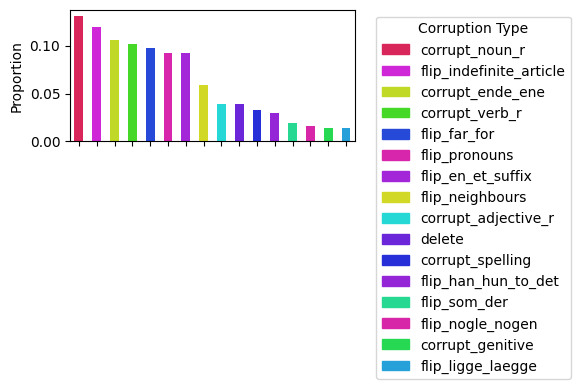

In [4]:
train_corr_type_prop = train['corruption_type'].value_counts(normalize=True)
plot_value_counts(train_corr_type_prop, save_filename="train")

In [5]:
train_corr_type_prop

corruption_type
corrupt_noun_r             0.130859
flip_indefinite_article    0.119141
corrupt_ende_ene           0.105469
corrupt_verb_r             0.101562
flip_far_for               0.097656
flip_pronouns              0.091797
flip_en_et_suffix          0.091797
flip_neighbours            0.058594
corrupt_adjective_r        0.039062
delete                     0.039062
corrupt_spelling           0.033203
flip_han_hun_to_det        0.029297
flip_som_der               0.019531
flip_nogle_nogen           0.015625
corrupt_genitive           0.013672
flip_ligge_laegge          0.013672
Name: proportion, dtype: float64

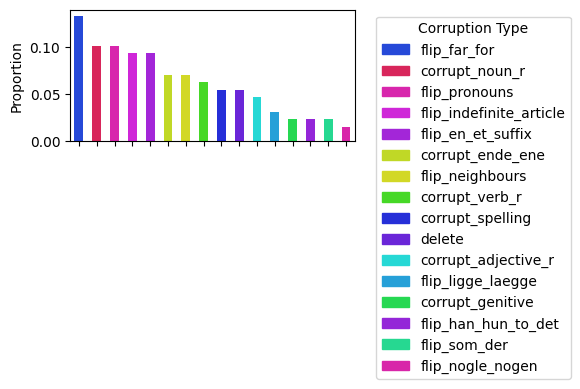

In [6]:
val_corr_type_prop = val['corruption_type'].value_counts(normalize=True)
plot_value_counts(val_corr_type_prop, save_filename="val")

In [7]:
val_corr_type_prop

corruption_type
flip_far_for               0.132812
corrupt_noun_r             0.101562
flip_pronouns              0.101562
flip_indefinite_article    0.093750
flip_en_et_suffix          0.093750
corrupt_ende_ene           0.070312
flip_neighbours            0.070312
corrupt_verb_r             0.062500
corrupt_spelling           0.054688
delete                     0.054688
corrupt_adjective_r        0.046875
flip_ligge_laegge          0.031250
corrupt_genitive           0.023438
flip_han_hun_to_det        0.023438
flip_som_der               0.023438
flip_nogle_nogen           0.015625
Name: proportion, dtype: float64

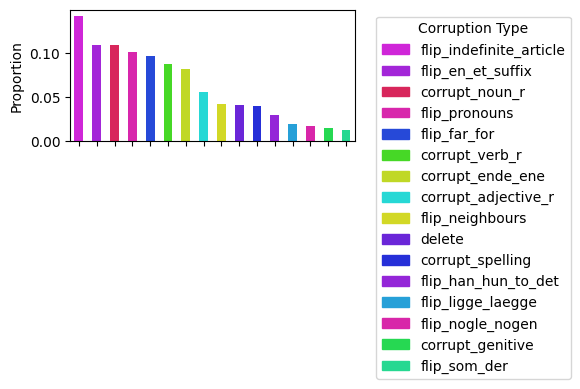

In [8]:
test_corr_type_prop = test['corruption_type'].value_counts(normalize=True)
plot_value_counts(test_corr_type_prop, save_filename="test")

In [9]:
test_corr_type_prop

corruption_type
flip_indefinite_article    0.141602
flip_en_et_suffix          0.109375
corrupt_noun_r             0.108398
flip_pronouns              0.100586
flip_far_for               0.096680
corrupt_verb_r             0.087891
corrupt_ende_ene           0.082031
corrupt_adjective_r        0.055664
flip_neighbours            0.041992
delete                     0.041016
corrupt_spelling           0.040039
flip_han_hun_to_det        0.030273
flip_ligge_laegge          0.019531
flip_nogle_nogen           0.017578
corrupt_genitive           0.014648
flip_som_der               0.012695
Name: proportion, dtype: float64

## Calculate splits distribution distance

In [12]:
def calculate_metrics(s1, s2):
    # Ensure both series have the same fields (i.e., same index), filling missing values with 0
    s1, s2 = s1.align(s2, join='outer', fill_value=0)

    # Extract the probability values for each distribution
    P = s1.values
    Q = s2.values

    # Normalize probabilities if not already normalized
    if not np.isclose(P.sum(), 1):
        p_sum = P.sum()
        P /= P.sum()
    if not np.isclose(Q.sum(), 1):
        Q /= Q.sum()

    # 1. Kullback-Leibler Divergence
    def kl_divergence(P, Q):
        return np.sum(kl_div(P, Q))

    kl_pq = kl_divergence(P, Q)
    kl_qp = kl_divergence(Q, P)

    # 2. Jensen-Shannon Divergence
    def js_divergence(P, Q):
        M = 0.5 * (P + Q)
        return 0.5 * (kl_divergence(P, M) + kl_divergence(Q, M))

    js_div = js_divergence(P, Q)

    # 3. Total Variation Distance
    tv_distance = 0.5 * np.sum(np.abs(P - Q))

    # 4. Wasserstein Distance (1st order)
    wasserstein_dist = wasserstein_distance(P, Q)

    # 5. Hellinger Distance
    def hellinger_distance(P, Q):
        return (1 / np.sqrt(2)) * np.sqrt(np.sum((np.sqrt(P) - np.sqrt(Q)) ** 2))

    hellinger_dist = hellinger_distance(P, Q)

    # Return all the metrics as a dictionary
    metrics = {
        'KL Divergence (P || Q)': kl_pq,
        'KL Divergence (Q || P)': kl_qp,
        'JS Divergence': js_div,
        'Total Variation Distance': tv_distance,
        'Wasserstein Distance': wasserstein_dist,
        'Hellinger Distance': hellinger_dist
    }

    return metrics

### train vs test

In [13]:
metrics = calculate_metrics(train_corr_type_prop, test_corr_type_prop)
metrics

{'KL Divergence (P || Q)': np.float64(0.019116267483405284),
 'KL Divergence (Q || P)': np.float64(0.018902428296505312),
 'JS Divergence': np.float64(0.0047368365126608716),
 'Total Variation Distance': np.float64(0.083984375),
 'Wasserstein Distance': np.float64(0.003662109375),
 'Hellinger Distance': np.float64(0.06888080471473511)}

### train vs val

In [14]:
metrics = calculate_metrics(train_corr_type_prop, val_corr_type_prop)
metrics

{'KL Divergence (P || Q)': np.float64(0.04934222604976036),
 'KL Divergence (Q || P)': np.float64(0.050580287960522455),
 'JS Divergence': np.float64(0.012369793610955054),
 'Total Variation Distance': np.float64(0.134765625),
 'Wasserstein Distance': np.float64(0.009521484375),
 'Hellinger Distance': np.float64(0.11148748176728057)}

### val vs test

In [15]:
metrics = calculate_metrics(val_corr_type_prop, test_corr_type_prop)
metrics

{'KL Divergence (P || Q)': np.float64(0.044484241630162125),
 'KL Divergence (Q || P)': np.float64(0.04286182333674147),
 'JS Divergence': np.float64(0.01084079511977468),
 'Total Variation Distance': np.float64(0.125),
 'Wasserstein Distance': np.float64(0.0078125),
 'Hellinger Distance': np.float64(0.10430395549911574)}

## Plot max potential corruption vs actual corruption proportions

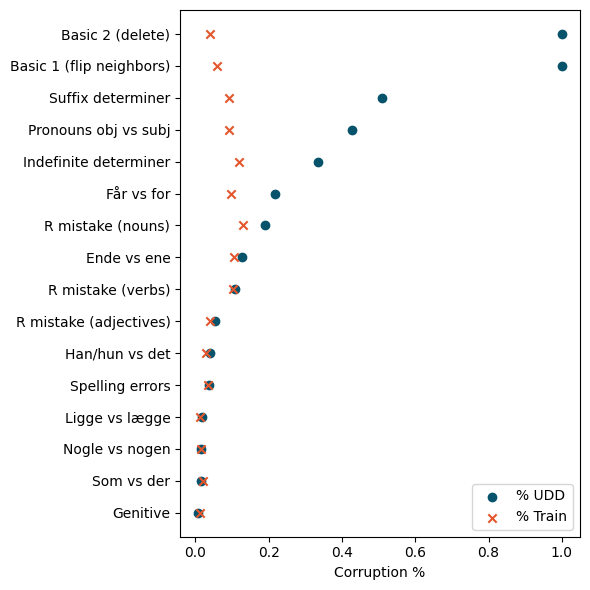

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

udd_data = {
    "Corruption Type": [
        "Basic 1 (flip neighbors)", "Basic 2 (delete)", "Suffix determiner", "Pronouns obj vs subj", "Indefinite determiner",
        "Får vs for", "R mistake (nouns)", "Ende vs ene", "R mistake (verbs)", "R mistake (adjectives)",
        "Han/hun vs det", "Spelling errors", "Ligge vs lægge", "Nogle vs nogen", "Som vs der", "Genitive"
    ],
    "% UDD": [
        1.0, 1.0, 0.510449, 0.428422, 0.335946, 0.217085, 0.189107, 0.127249, 0.107612, 0.054118,
        0.038674, 0.037909, 0.019073, 0.016469, 0.015147, 0.007839
    ]
}

proportion_data = {
    "Corruption Type": [
        "R mistake (nouns)", "Indefinite determiner", "Ende vs ene", "R mistake (verbs)", "Får vs for",
        "Pronouns obj vs subj", "Suffix determiner", "Basic 1 (flip neighbors)", "R mistake (adjectives)",
        "Basic 2 (delete)", "Spelling errors", "Han/hun vs det", "Som vs der", "Nogle vs nogen",
        "Genitive", "Ligge vs lægge"
    ],
    "Proportion": [
        0.130859, 0.119141, 0.105469, 0.101562, 0.097656, 0.091797, 0.091797, 0.058594, 0.039062,
        0.039062, 0.033203, 0.029297, 0.019531, 0.015625, 0.013672, 0.013672
    ]
}

# Create DataFrames
udd_df = pd.DataFrame(udd_data)
prop_df = pd.DataFrame(proportion_data)

# Merge on "Corruption Type"
merged_df = pd.merge(udd_df, prop_df, on="Corruption Type", how="outer").fillna(0)

# Sort by % UDD in ascending order
merged_df_sorted = merged_df.sort_values(by="% UDD", ascending=True).reset_index(drop=True)

# Plot horizontal scatter
plt.figure(figsize=(6, 6))
y = range(len(merged_df_sorted))

plt.scatter(merged_df_sorted["% UDD"], y, label="% UDD", marker="o", color="#07536c")
plt.scatter(merged_df_sorted["Proportion"], y, label="% Train", marker="x", color="#e4572e")

# Formatting
plt.yticks(y, merged_df_sorted["Corruption Type"])
plt.xlabel("Corruption %")
# plt.title("Comparison of % UDD vs Proportion by Corruption Type (Sorted Ascending by % UDD)")
plt.legend()
plt.tight_layout()
plt.savefig("corruption_plot.png", dpi=300, bbox_inches="tight")
plt.show()